## Project - 01

Contributors: Pratyush Sudhakar (ps2245), Aditya Syam (as2839), Cedric Orton-Urbina (ceo29)

### Column Pivoting QR Factorization (Goals 1-3)

For this part, we will implement a $QR$ Factorization of a given matrix $A$ with complete pivoting.

**Strategy**: We implement the QR Factorization with complete pivoting as proposed by Businger & Golub (1965), using the strategy to store the squared 2-norms of columns of the matrix $A$ in array $S$, and in each iteration ($k$), update the array entries by subtracting the squares of the top row.

$$
S_j^{(k+1)} = S_j^{(k)} - (a_{k, j}^{(k+1)})^2
$$

### Compressing a Spimple Neural Network

**Step 1**: Use a prebuilt $qr$ to compute the $q_k$, $r_k$ as mentioned at the end of the report.<br>
**Step 2**: Implement the helper functions (softmax, ReLu, etc...).<br>
**Step 3**: Implement the model in $eq^n(10)$ - at this point we are given the $W$ matrices, hence no need to compute them just yet.<br>
**Step 4**: Implement SVD QR Factorization, then compare 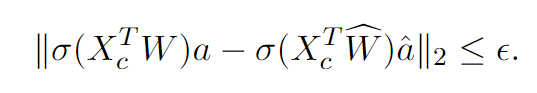 where the term is the matrix that we are asked to compute.<br>
**Step 5**: Vary $\epsilon$ so less columns are selected ($k$ decreases with decrease in $\epsilon$).<br>